## -- 기본 AutoEncoder --

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## 데이터 준비

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## AutoEncoder 모델 생성

In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

- encoder는 데이터세트를 784차원에서 잠재 공간으로 압축하는 방법을 배우고, decoder는 원본 이미지를 재구성하는 방법을 배운다.

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## 모델 훈련

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 880us/step - loss: 0.0235 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 2s 868us/step - loss: 0.0115 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 2s 834us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 2s 837us/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 2s 836us/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 2s 839us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 2s 868us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 853us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 2s 840us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 2s 841u

## 테스트

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

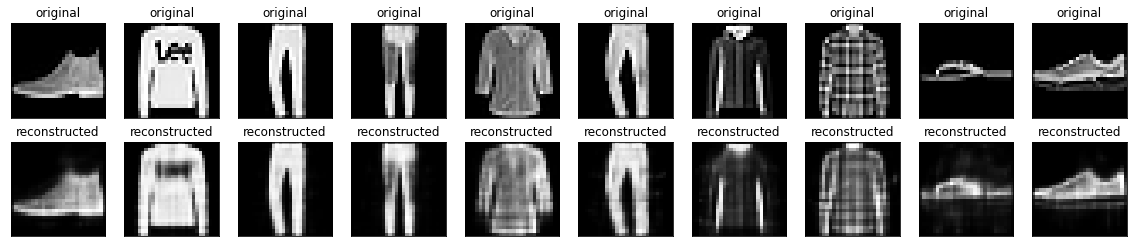

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## -- 이상탐지 --

- 심전도 데이터 이용 -> 비정상 리듬 / 정상 리듬 분류 -> 비정상 리듬을 식별

## 데이터 준비

In [10]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## 데이터 전처리

In [11]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [12]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [13]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

- 정상리듬

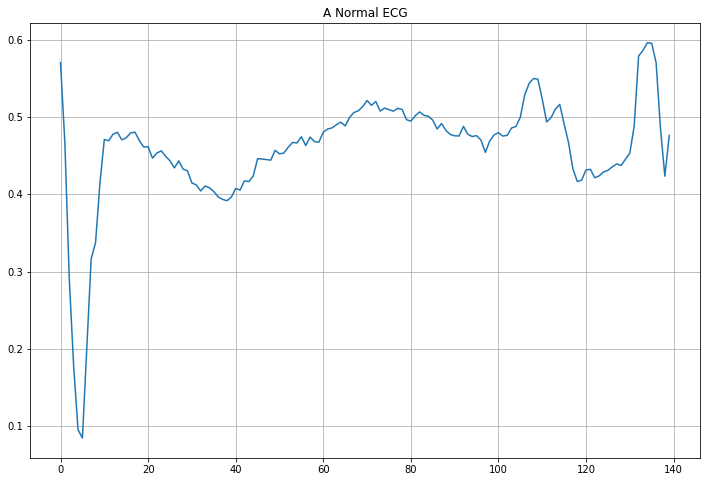

In [16]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

- 비정상리듬

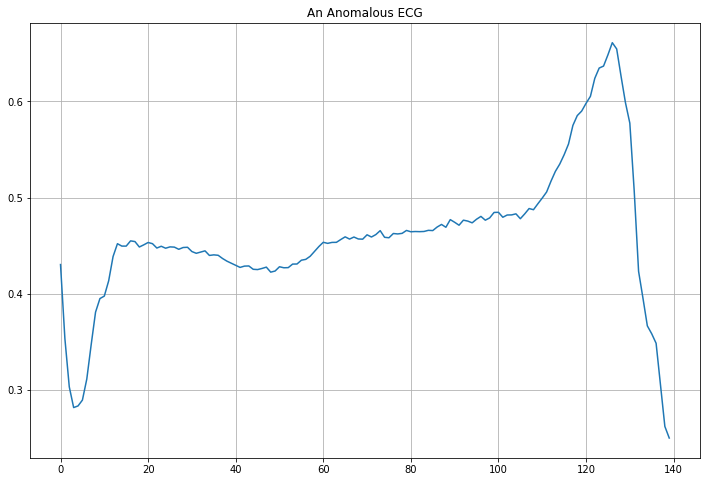

In [17]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## 모델 생성

In [18]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [19]:
autoencoder.compile(optimizer='adam', loss='mae')

In [20]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0581 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0565 - val_loss: 0.0521
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0546 - val_loss: 0.0504
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0521 - val_loss: 0.0487
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0489 - val_loss: 0.0473
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0459
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0426 - val_loss: 0.0439
Epoch 8/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0392 - val_loss: 0.0420
Epoch 9/20
5/5 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0409
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.0398
Epoch 11/20
5/5 [=====================

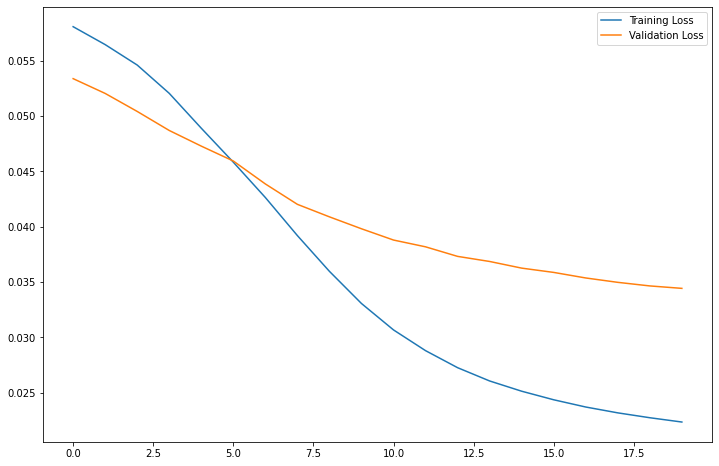

In [22]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

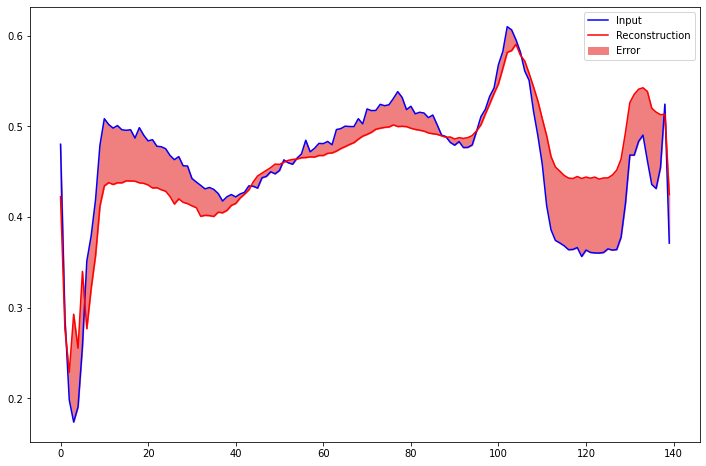

In [24]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(12,8))
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

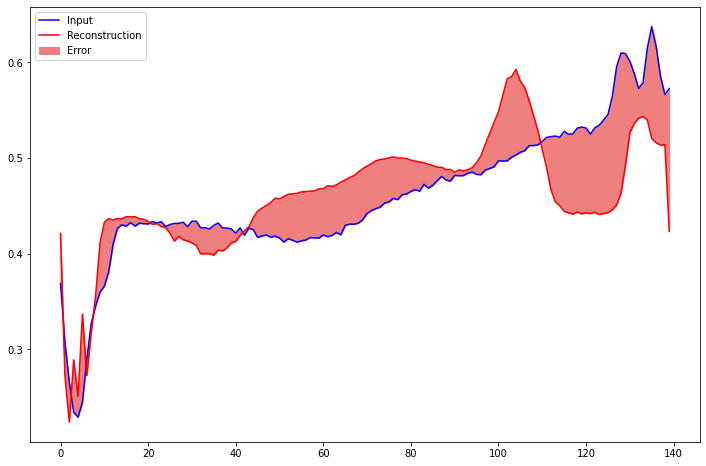

In [25]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(12,8))
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

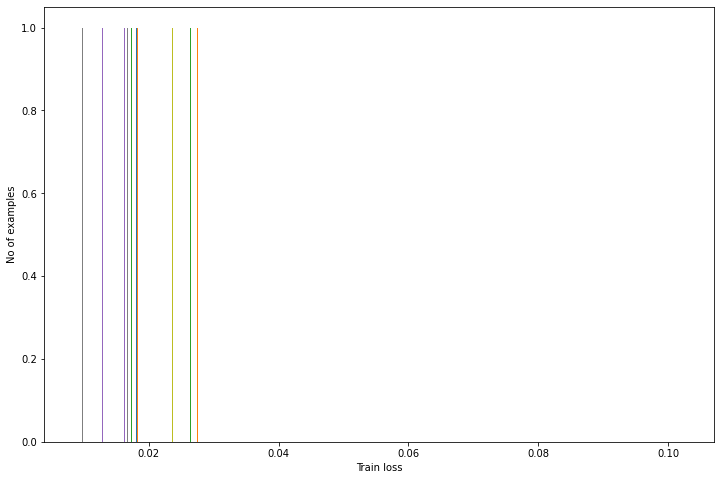

In [26]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.figure(figsize=(12,8))
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [27]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.034322593


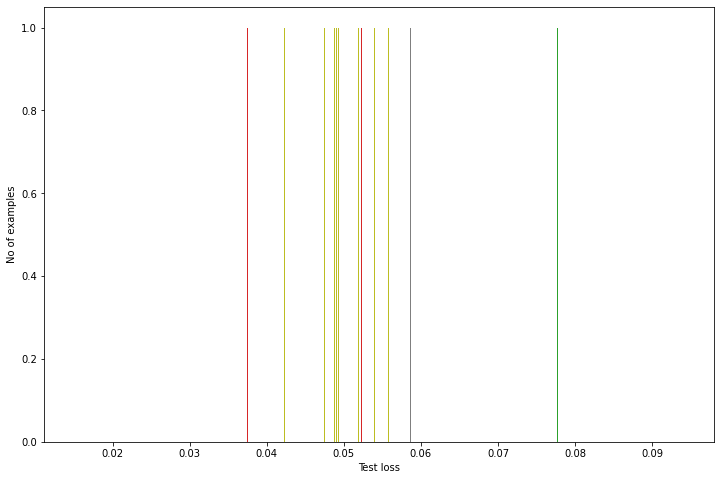

In [29]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.figure(figsize=(12,8))
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [30]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [31]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429
